## <center>IBM Data Science Capstone Course Final Project</center>

# IMPORTANT!
# Please use nbviewer to render this notebook and see all the outputs.
# Go to https://nbviewer.jupyter.org, then input the link to this notebook.

In [1]:
import random as rd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns; 
sns.set(color_codes=True)

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import requests

#from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium

import math as mth
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pandas import DataFrame

import time

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [2]:
# The NYC Covid data was downloaded from the City's github

NYC_Covid = pd.read_csv('NYC_Covid.csv')
print(NYC_Covid.shape)
NYC_Covid.head()

(177, 10)


,Zipcode,Neighborhood,Borough,Pos_cases,Infection_rate,Population,Deaths,Death_rate,Pct_positive,Total_cases
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,433,1837.62,23563.03,26,110.34,6.04,7165
1,10002,Chinatown/Lower East Side,Manhattan,1305,1700.21,76755.41,161,209.76,8.64,15105
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,525,975.81,53801.62,34,63.20,4.47,11750
3,10004,Financial District,Manhattan,39,1068.32,3650.61,1,27.39,4.83,807
4,10005,Financial District,Manhattan,91,1083.84,8396.11,2,23.82,4.75,1915


In [3]:
# Create a reduced version of Covid data for use later

NYC_Covid1 = NYC_Covid[['Zipcode','Population','Infection_rate','Death_rate']]
NYC_Covid1.head()

,Zipcode,Population,Infection_rate,Death_rate
0,10001,23563.03,1837.62,110.34
1,10002,76755.41,1700.21,209.76
2,10003,53801.62,975.81,63.20
3,10004,3650.61,1068.32,27.39
4,10005,8396.11,1083.84,23.82


In [4]:
# New York State zip codes and latitude-longitude data

NYS_zip_to_lat_lon_df = pd.read_csv('NYS_zip_to_lat_lon.csv')
print(NYS_zip_to_lat_lon_df.shape)
NYS_zip_to_lat_lon_df.head()

(2278, 3)


,Zipcode,Latitude,Longitude
0,10001,40.750742,-73.99653
1,10002,40.717040,-73.98700
2,10003,40.732509,-73.98935
3,10005,40.706019,-74.00858
4,10006,40.707904,-74.01342


In [5]:
# Merge the latitude-longitude data by NYC zip code

NYC_df = NYC_Covid.join(NYS_zip_to_lat_lon_df.set_index('Zipcode'), on='Zipcode')
print(NYC_df.shape)
NYC_df.head()

(177, 12)


,Zipcode,Neighborhood,Borough,Pos_cases,Infection_rate,Population,Deaths,Death_rate,Pct_positive,Total_cases,Latitude,Longitude
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,433,1837.62,23563.03,26,110.34,6.04,7165,40.750742,-73.99653
1,10002,Chinatown/Lower East Side,Manhattan,1305,1700.21,76755.41,161,209.76,8.64,15105,40.717040,-73.98700
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,525,975.81,53801.62,34,63.20,4.47,11750,40.732509,-73.98935
3,10004,Financial District,Manhattan,39,1068.32,3650.61,1,27.39,4.83,807,NaN,NaN
4,10005,Financial District,Manhattan,91,1083.84,8396.11,2,23.82,4.75,1915,40.706019,-74.00858


In [6]:
# Remove any rows with missing data (rows with NaN cells)

print(NYC_df.shape)  # Before removing NaN
NYC_df = NYC_df.dropna()
NYC_df.shape         # After removing NaN, it looks like there are 3 rows with NaN cells

(177, 12)


(174, 12)

In [7]:
# Take a look at number of zipcodes by borough, we will use this data to compute average area of a zipcode by borough

Borough_zipcode_counts = NYC_df['Borough'].value_counts()
print(Borough_zipcode_counts)

Queens           59
Manhattan        41
Brooklyn         37
Bronx            25
Staten Island    12
Name: Borough, dtype: int64


In [8]:
# Convert zipcode average surface area of each borough into a radius.
# This data will be used to download venues data from Foursquare

NYC_area = pd.read_csv('NYC_Surface_Area.csv')
#print(NYC_area)

if 'Avg_radius' in NYC_area.columns:
    NYC_area.drop('Avg_radius', axis=1, inplace=True)
NYC_area.insert(2,'Avg_radius',0.0,True)

rad = []
for idx, row in NYC_area.iterrows():
    rad.append(mth.sqrt(row['Square_km'] / Borough_zipcode_counts[row['Borough']] / mth.pi) * 1000.0)

NYC_area['Avg_radius'] = rad


print(NYC_area.head())

         Borough  Square_km   Avg_radius
0          Bronx     109.04  1178.278575
1       Brooklyn     183.42  1256.167480
2      Manhattan      59.13   677.543331
3         Queens     281.09  1231.464100
4  Staten Island     151.18  2002.541897


In [10]:
# Add the average radius data to the NYC data set

if 'Avg_radius' in NYC_df.columns:
    NYC_df.drop('Avg_radius', axis=1, inplace=True)
NYC_df.insert(12,'Avg_radius',0.0,True)
print(NYC_df.head())

   Zipcode                             Neighborhood    Borough  Pos_cases  \
0    10001               Chelsea/NoMad/West Chelsea  Manhattan        433   
1    10002                Chinatown/Lower East Side  Manhattan       1305   
2    10003  East Village/Gramercy/Greenwich Village  Manhattan        525   
4    10005                       Financial District  Manhattan         91   
5    10006                       Financial District  Manhattan         39   

   Infection_rate  Population  Deaths  Death_rate  Pct_positive  Total_cases  \
0         1837.62    23563.03      26      110.34          6.04         7165   
1         1700.21    76755.41     161      209.76          8.64        15105   
2          975.81    53801.62      34       63.20          4.47        11750   
4         1083.84     8396.11       2       23.82          4.75         1915   
5         1127.89     3457.77       0        0.00          4.62          845   

    Latitude  Longitude  Avg_radius  
0  40.750742  -73.

In [11]:
# Adding radius data to NYC data

rad = []
for idx, row in NYC_df.iterrows():
    radius = 0.0
    for idx, row1 in NYC_area.iterrows():
        if row['Borough'] == row1['Borough']:
            radius = row1['Avg_radius']
            break
    rad.append(radius)

            
NYC_df['Avg_radius'] = rad

print(NYC_df.head())

   Zipcode                             Neighborhood    Borough  Pos_cases  \
0    10001               Chelsea/NoMad/West Chelsea  Manhattan        433   
1    10002                Chinatown/Lower East Side  Manhattan       1305   
2    10003  East Village/Gramercy/Greenwich Village  Manhattan        525   
4    10005                       Financial District  Manhattan         91   
5    10006                       Financial District  Manhattan         39   

   Infection_rate  Population  Deaths  Death_rate  Pct_positive  Total_cases  \
0         1837.62    23563.03      26      110.34          6.04         7165   
1         1700.21    76755.41     161      209.76          8.64        15105   
2          975.81    53801.62      34       63.20          4.47        11750   
4         1083.84     8396.11       2       23.82          4.75         1915   
5         1127.89     3457.77       0        0.00          4.62          845   

    Latitude  Longitude  Avg_radius  
0  40.750742  -73.

In [12]:
# Take a look at the last few rows also

NYC_df.tail()

,Zipcode,Neighborhood,Borough,Pos_cases,Infection_rate,Population,Deaths,Death_rate,Pct_positive,Total_cases,Latitude,Longitude,Avg_radius
172,11691,Edgemere/Far Rockaway,Queens,2629,4059.67,64759.02,373,575.98,16.15,16276,40.600020,-73.75962,1231.4641
173,11692,Arverne/Edgemere,Queens,693,3444.29,20120.24,93,462.22,14.29,4851,40.592939,-73.79568,1231.4641
174,11693,Arverne/Broad Channel,Queens,349,2818.77,12381.27,29,234.22,14.76,2365,40.596959,-73.81978,1231.4641
175,11694,Belle Harbor-Neponsit/Rockaway Park,Queens,775,3807.27,20355.78,90,442.13,15.95,4858,40.576490,-73.84721,1231.4641
176,11697,Breezy Point,Queens,113,3195.08,3536.69,4,113.10,7.41,1524,40.560167,-73.90891,1231.4641


In [13]:
# This function retrieves venues from FourSquare for each neighborhood

def getNearbyVenues(zipcodes, latitudes, longitudes, radius):
    
    venues_list=[]
    for zipcode, lat, lng, rad in zip(zipcodes, latitudes, longitudes, radius):
        print(zipcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# Get venues data from Foursquare

CLIENT_ID = 'VFGZW2NEB45QI5RY22SQNXRRAOTC5F53GRJA25WUFM0REIHY' # your Foursquare ID
CLIENT_SECRET = '2YAV1STUPRKCDV2FCK4GNCHNGZF0T0YFKZLL01TQGIYEAVLT' # your Foursquare Secret

# Foursquare is imposing a ceiling of 100 
LIMIT=100
VERSION = '20180604'

print(NYC_df.shape)

NYC_venues = getNearbyVenues(zipcodes=NYC_df['Zipcode'],
                                   latitudes=NYC_df['Latitude'],
                                   longitudes=NYC_df['Longitude'],
                                   radius=NYC_df['Avg_radius']     
                             )

# Save venues data in csv file so we won't have to use Foursquare repeatedly, it takes a long time
NYC_venues.to_csv(path_or_buf="NYC_venues.csv", index=False)

print(NYC_venues.shape)
NYC_venues.head()

In [14]:
# Run this cell if we're not downloading from Foursquare
# Load the venues data from previously saved csv file to avoid accessing Foursquare

NYC_venues = pd.read_csv('NYC_venues.csv')
print(NYC_venues.shape)
NYC_venues.head()

(14766, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10001,40.750742,-73.99653,New York Pizza Suprema,40.750124,-73.994992,Pizza Place
1,10001,40.750742,-73.99653,Music Choice,40.752632,-73.994585,Music Venue
2,10001,40.750742,-73.99653,Bluestone Lane,40.752068,-73.998848,Coffee Shop
3,10001,40.750742,-73.99653,Madison Square Garden,40.750752,-73.993542,Basketball Stadium
4,10001,40.750742,-73.99653,B&H Photo Video,40.753277,-73.996470,Camera Store


In [15]:
# Create a categories dataset 

categories = NYC_venues['Venue Category'].unique()
print('There are {} unique venue categories.'.format(len(NYC_venues['Venue Category'].unique())))

Categories_df = DataFrame(categories)
print(Categories_df.shape)

# Save the categories into a csv file for manual mapping to a small number of aggregate categories
Categories_df.to_csv(path_or_buf="Categories.csv", index=False)

There are 456 unique venue categories.
(456, 1)


In [16]:
# Load in the category mappings created manually

Category_map_df = pd.read_csv('Categories_mapping.csv')
print(Category_map_df.shape)
print(Category_map_df.head())

# Add a column to the venues dataframe to store the mapped category data

if 'Mapped_category' in NYC_venues.columns:
    NYC_venues.drop('Mapped_category', axis=1, inplace=True)
NYC_venues.insert(7, 'Mapped_category', 'Unknown', allow_duplicates=False)
NYC_venues.head()

(454, 2)
           Categories        Mapping
0         Pizza Place  Take_out_food
1         Music Venue  Entertainment
2  Basketball Stadium  Entertainment
3         Coffee Shop  Take_out_food
4        Camera Store    Merchandise


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Mapped_category
0,10001,40.750742,-73.99653,New York Pizza Suprema,40.750124,-73.994992,Pizza Place,Unknown
1,10001,40.750742,-73.99653,Music Choice,40.752632,-73.994585,Music Venue,Unknown
2,10001,40.750742,-73.99653,Bluestone Lane,40.752068,-73.998848,Coffee Shop,Unknown
3,10001,40.750742,-73.99653,Madison Square Garden,40.750752,-73.993542,Basketball Stadium,Unknown
4,10001,40.750742,-73.99653,B&H Photo Video,40.753277,-73.996470,Camera Store,Unknown


In [ ]:
# Put the mapped category data into the venues dataframe
# Run this cell only if there is new data, otherwise load the data from saved csv file, see next cell

for idx1 in NYC_venues.index: 
    print(NYC_venues['Venue Category'][idx1])
    for idx2 in Category_map_df.index:
        if (NYC_venues.loc[idx1, 'Venue Category'] == Category_map_df.loc[idx2, 'Categories']):
            NYC_venues.loc[idx1, 'Mapped_category'] = Category_map_df.loc[idx2, 'Mapping']

# The above takes a long time so let's save the mapped data into a csv

NYC_venues.to_csv(path_or_buf="NYC_venues_mapped.csv", index=False)

print(NYC_venues.shape)
NYC_venues.head()

In [17]:
# Run this cell if loading mapped venues data from csv

NYC_venues = pd.read_csv('NYC_venues_mapped.csv')

In [18]:
# Take a look at the mapped categories
print(NYC_venues.shape)
NYC_venues['Mapped_category'].value_counts()

(14766, 8)


Take_out_food      4166
Restaurant         3776
Merchandise        2164
Social_drinking     963
Outdoor             856
Markets             725
Services            602
Exercise            565
Transportation      378
Entertainment       299
Housing             131
Education            94
Community            38
Unknown               8
ret                   1
Name: Mapped_category, dtype: int64

In [19]:
# Convert venues data into one hot format with each mapped category having its own column

NYC_onehot = pd.get_dummies(NYC_venues[['Mapped_category']],prefix="",prefix_sep="")
NYC_onehot['Zipcode'] = NYC_venues['Neighborhood']
fixed_columns = [NYC_onehot.columns[-1]] + list(NYC_onehot.columns[:-1])
NYC_onehot = NYC_onehot[fixed_columns]

NYC_by_zip = NYC_onehot.groupby('Zipcode').sum().reset_index()

print(NYC_by_zip.shape)
NYC_by_zip.head()

(174, 16)


,Zipcode,Community,Education,Entertainment,Exercise,Housing,Markets,Merchandise,Outdoor,Restaurant,Services,Social_drinking,Take_out_food,Transportation,Unknown,ret
0,10001,0,3,12,6,3,3,12,5,18,2,8,28,0,0,0
1,10002,0,0,3,2,0,3,14,0,35,1,13,29,0,0,0
2,10003,0,2,3,4,0,8,11,5,28,0,8,30,0,0,1
3,10005,1,0,1,6,1,1,13,7,23,4,8,32,3,0,0
4,10006,3,1,2,5,6,3,12,19,12,2,7,27,1,0,0


In [20]:
# Merge venues data with Covid data

NYC_by_zip = pd.merge(NYC_by_zip, NYC_Covid1, on='Zipcode')
NYC_by_zip.head()

,Zipcode,Community,Education,Entertainment,Exercise,Housing,Markets,Merchandise,Outdoor,Restaurant,Services,Social_drinking,Take_out_food,Transportation,Unknown,ret,Population,Infection_rate,Death_rate
0,10001,0,3,12,6,3,3,12,5,18,2,8,28,0,0,0,23563.03,1837.62,110.34
1,10002,0,0,3,2,0,3,14,0,35,1,13,29,0,0,0,76755.41,1700.21,209.76
2,10003,0,2,3,4,0,8,11,5,28,0,8,30,0,0,1,53801.62,975.81,63.20
3,10005,1,0,1,6,1,1,13,7,23,4,8,32,3,0,0,8396.11,1083.84,23.82
4,10006,3,1,2,5,6,3,12,19,12,2,7,27,1,0,0,3457.77,1127.89,0.00


In [21]:
# Convert venue data to per capita data

cols = list(NYC_by_zip)
cols = cols[1:14]
print(cols)

Per_capita = NYC_by_zip.copy()

for i in Per_capita.index:
    for c in cols:
        Per_capita.loc[i,c] =  1000 * Per_capita.loc[i,c] / Per_capita.loc[i,'Population']

# Save data into csv file for review
Per_capita.to_csv(path_or_buf="Per_capita.csv", index=False)
Per_capita.head()

['Community', 'Education', 'Entertainment', 'Exercise', 'Housing', 'Markets', 'Merchandise', 'Outdoor', 'Restaurant', 'Services', 'Social_drinking', 'Take_out_food', 'Transportation']


,Zipcode,Community,Education,Entertainment,Exercise,Housing,Markets,Merchandise,Outdoor,Restaurant,Services,Social_drinking,Take_out_food,Transportation,Unknown,ret,Population,Infection_rate,Death_rate
0,10001,0.000000,0.127318,0.509272,0.254636,0.127318,0.127318,0.509272,0.212197,0.763909,0.084879,0.339515,1.188302,0.000000,0,0,23563.03,1837.62,110.34
1,10002,0.000000,0.000000,0.039085,0.026057,0.000000,0.039085,0.182398,0.000000,0.455994,0.013028,0.169369,0.377824,0.000000,0,0,76755.41,1700.21,209.76
2,10003,0.000000,0.037174,0.055760,0.074347,0.000000,0.148694,0.204455,0.092934,0.520430,0.000000,0.148694,0.557604,0.000000,0,1,53801.62,975.81,63.20
3,10005,0.119103,0.000000,0.119103,0.714617,0.119103,0.119103,1.548336,0.833719,2.739364,0.476411,0.952822,3.811289,0.357308,0,0,8396.11,1083.84,23.82
4,10006,0.867611,0.289204,0.578407,1.446019,1.735222,0.867611,3.470445,5.494871,3.470445,0.578407,2.024426,7.808501,0.289204,0,0,3457.77,1127.89,0.00


C:\Users\mtcye\anaconda3\Lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

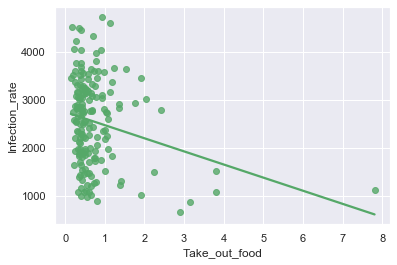

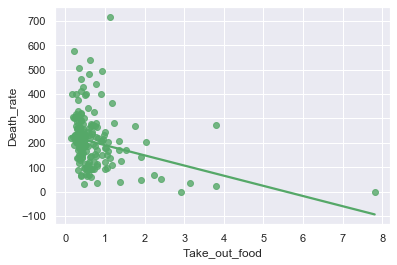

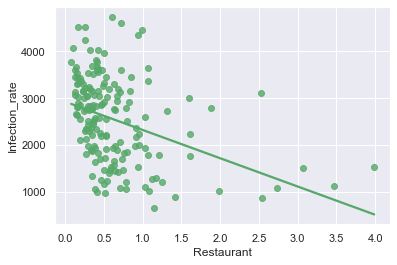

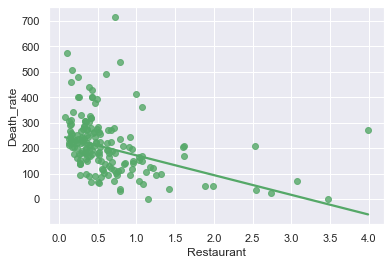

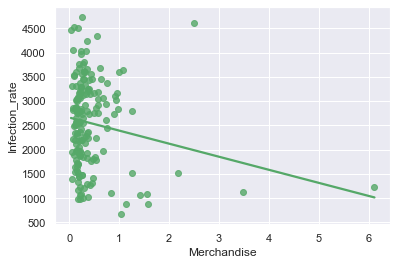

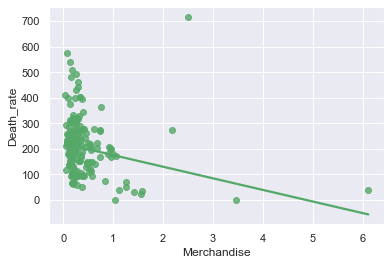

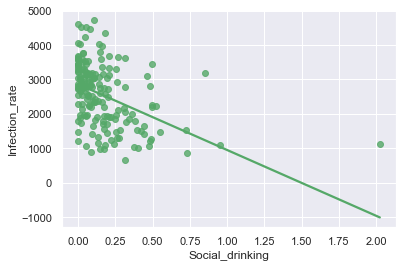

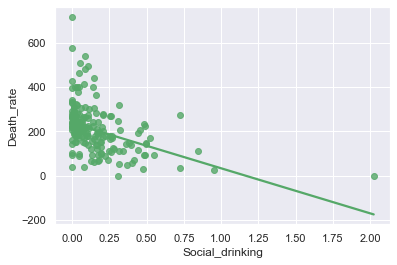

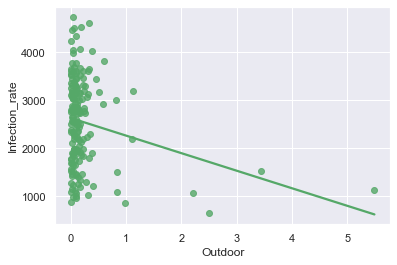

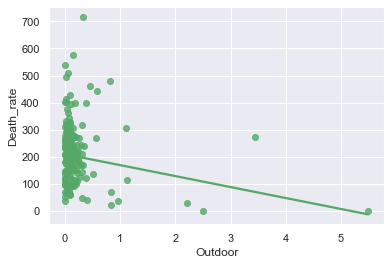

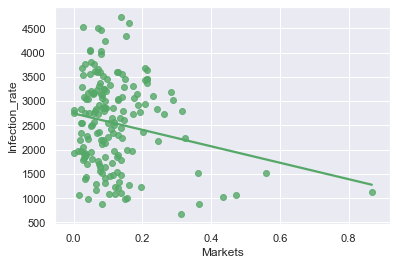

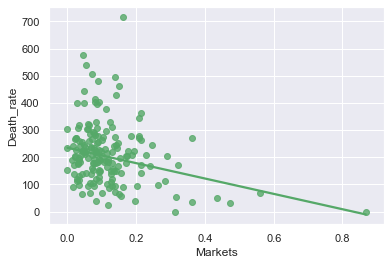

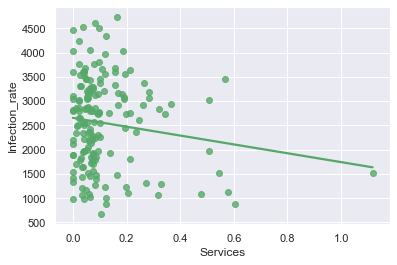

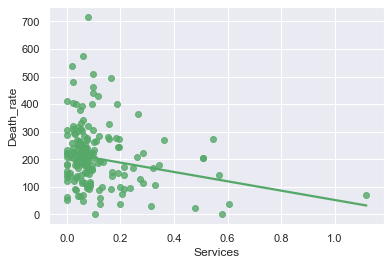

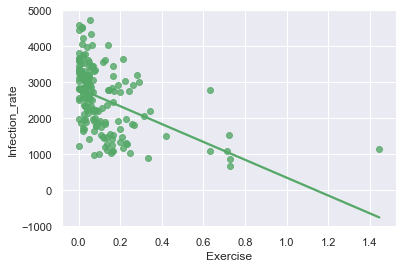

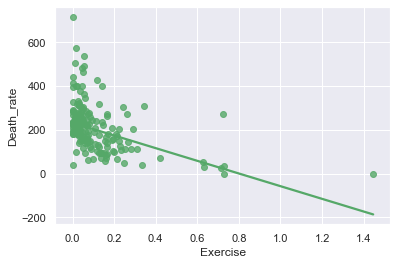

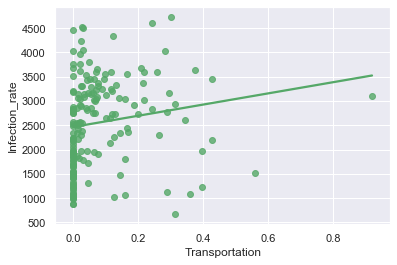

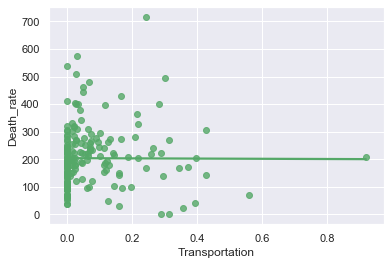

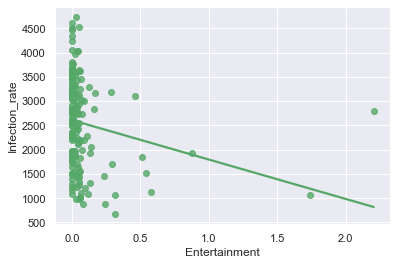

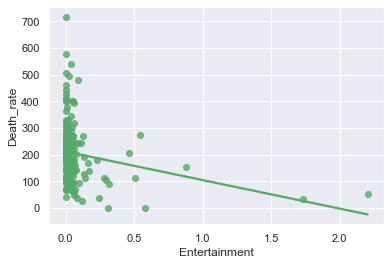

<Figure size 432x288 with 0 Axes>

In [22]:
plt.close('all')
ord = 1

ax = sns.regplot(x=Per_capita['Take_out_food'], y=Per_capita['Infection_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Per_capita['Take_out_food'], y=Per_capita['Death_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Per_capita['Restaurant'], y=Per_capita['Infection_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Per_capita['Restaurant'], y=Per_capita['Death_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Per_capita['Merchandise'], y=Per_capita['Infection_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Per_capita['Merchandise'], y=Per_capita['Death_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Per_capita['Social_drinking'], y=Per_capita['Infection_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Per_capita['Social_drinking'], y=Per_capita['Death_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Per_capita['Outdoor'], y=Per_capita['Infection_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Per_capita['Outdoor'], y=Per_capita['Death_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Per_capita['Markets'], y=Per_capita['Infection_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Per_capita['Markets'], y=Per_capita['Death_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Per_capita['Services'], y=Per_capita['Infection_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Per_capita['Services'], y=Per_capita['Death_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Per_capita['Exercise'], y=Per_capita['Infection_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Per_capita['Exercise'], y=Per_capita['Death_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Per_capita['Transportation'], y=Per_capita['Infection_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Per_capita['Transportation'], y=Per_capita['Death_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Per_capita['Entertainment'], y=Per_capita['Infection_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Per_capita['Entertainment'], y=Per_capita['Death_rate'], color="g", order=ord, ci=None, robust=True)
plt.figure()

In [23]:
# Convert venue data to percent data

cols = list(NYC_by_zip)
cols = cols[1:14]

Percent = NYC_by_zip.copy()

for i in Percent.index:
    total = 0
    for m in cols:
        total += Percent.loc[i,m]
    for m in cols:
        Percent.loc[i, m] = 100.0 * Percent.loc[i,m] / total
        
Percent.head()

,Zipcode,Community,Education,Entertainment,Exercise,Housing,Markets,Merchandise,Outdoor,Restaurant,Services,Social_drinking,Take_out_food,Transportation,Unknown,ret,Population,Infection_rate,Death_rate
0,10001,0.0,3.000000,12.000000,6.000000,3.0,3.000000,12.000000,5.000000,18.000000,2.0,8.000000,28.00000,0.0,0,0,23563.03,1837.62,110.34
1,10002,0.0,0.000000,3.000000,2.000000,0.0,3.000000,14.000000,0.000000,35.000000,1.0,13.000000,29.00000,0.0,0,0,76755.41,1700.21,209.76
2,10003,0.0,2.020202,3.030303,4.040404,0.0,8.080808,11.111111,5.050505,28.282828,0.0,8.080808,30.30303,0.0,0,1,53801.62,975.81,63.20
3,10005,1.0,0.000000,1.000000,6.000000,1.0,1.000000,13.000000,7.000000,23.000000,4.0,8.000000,32.00000,3.0,0,0,8396.11,1083.84,23.82
4,10006,3.0,1.000000,2.000000,5.000000,6.0,3.000000,12.000000,19.000000,12.000000,2.0,7.000000,27.00000,1.0,0,0,3457.77,1127.89,0.00


C:\Users\mtcye\anaconda3\Lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

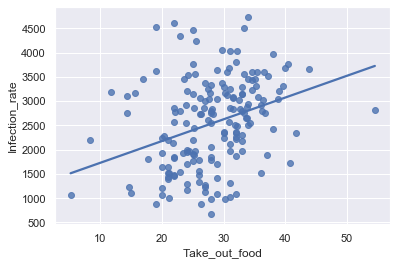

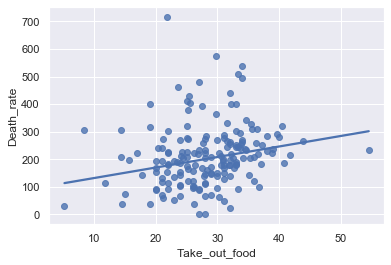

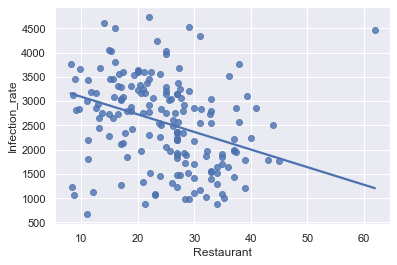

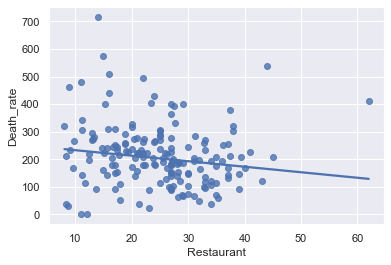

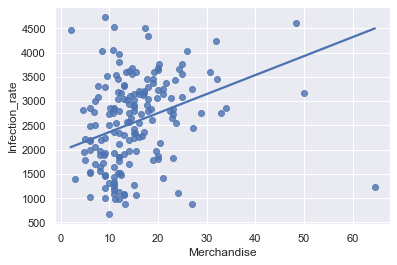

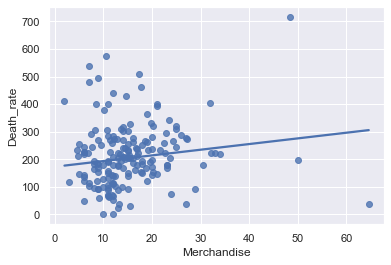

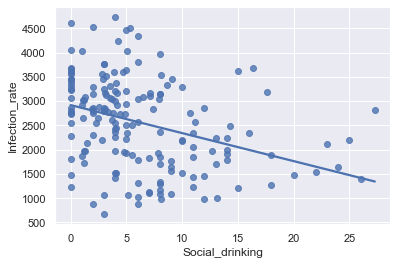

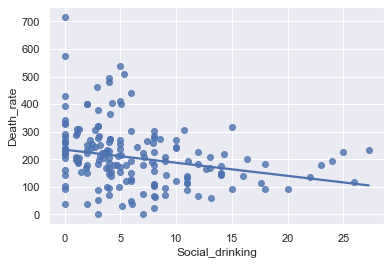

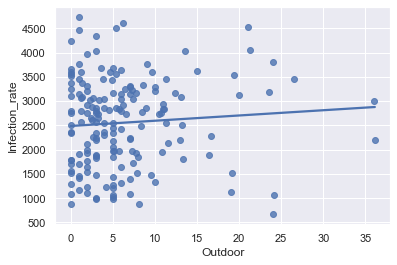

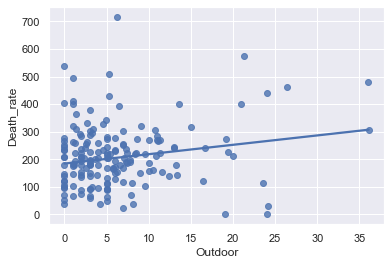

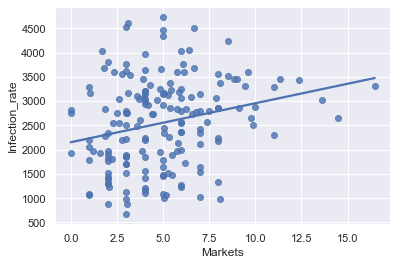

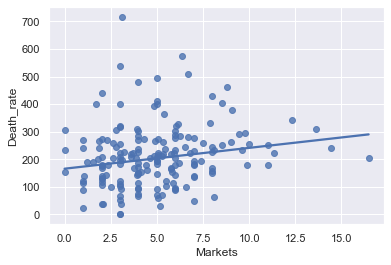

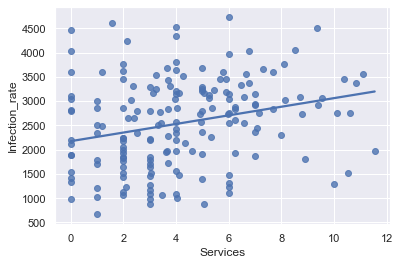

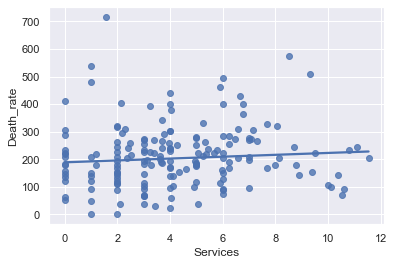

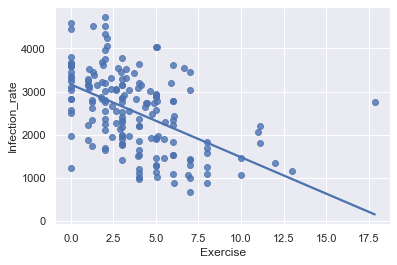

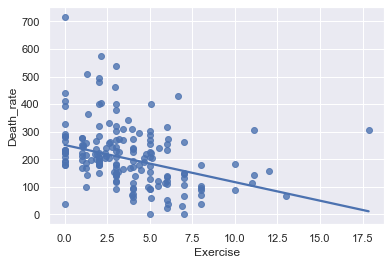

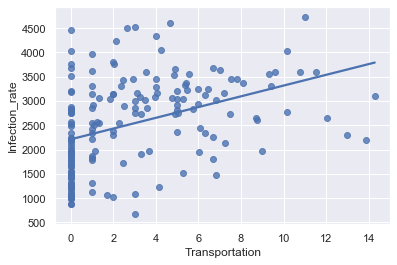

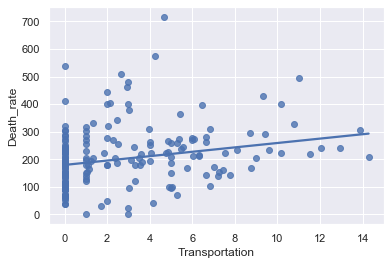

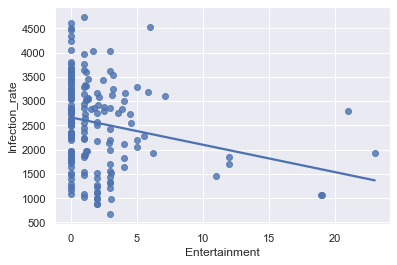

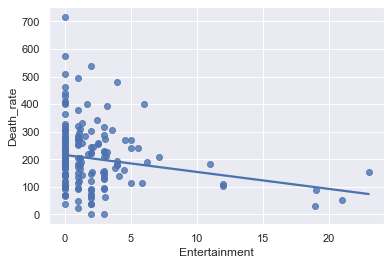

<Figure size 432x288 with 0 Axes>

In [24]:
plt.close('all')
ord = 1

ax = sns.regplot(x=Percent['Take_out_food'], y=Percent['Infection_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Percent['Take_out_food'], y=Percent['Death_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Percent['Restaurant'], y=Percent['Infection_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Percent['Restaurant'], y=Percent['Death_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Percent['Merchandise'], y=Percent['Infection_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Percent['Merchandise'], y=Percent['Death_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Percent['Social_drinking'], y=Percent['Infection_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Percent['Social_drinking'], y=Percent['Death_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Percent['Outdoor'], y=Percent['Infection_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Percent['Outdoor'], y=Percent['Death_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Percent['Markets'], y=Percent['Infection_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Percent['Markets'], y=Percent['Death_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Percent['Services'], y=Percent['Infection_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Percent['Services'], y=Percent['Death_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Percent['Exercise'], y=Percent['Infection_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Percent['Exercise'], y=Percent['Death_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Percent['Transportation'], y=Percent['Infection_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Percent['Transportation'], y=Percent['Death_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()

ax = sns.regplot(x=Percent['Entertainment'], y=Percent['Infection_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()
ax = sns.regplot(x=Percent['Entertainment'], y=Percent['Death_rate'], color="b", order=ord, ci=None, robust=True)
plt.figure()

In [25]:
# Select the top 10 categories for analyses

cols = list(Per_capita.columns[3:14])
print(cols)
cols.remove('Housing')
print(cols)

['Entertainment', 'Exercise', 'Housing', 'Markets', 'Merchandise', 'Outdoor', 'Restaurant', 'Services', 'Social_drinking', 'Take_out_food', 'Transportation']
['Entertainment', 'Exercise', 'Markets', 'Merchandise', 'Outdoor', 'Restaurant', 'Services', 'Social_drinking', 'Take_out_food', 'Transportation']


In [26]:
# Compute simple regression parameters

cols = list(Per_capita.columns[3:14])
cols.remove('Housing')
print(cols)

slopes = list()
RSq = list()

for col in cols:
    x = np.array(Per_capita[col]).reshape(-1,1)
    y = Per_capita['Infection_rate']
    reg = LinearRegression().fit(x, y)
    slopes.append(reg.coef_[0])
    RSq.append(reg.score(x,y))            

Inf_stats = pd.DataFrame()
Inf_stats['Venues'] =  cols
Inf_stats['PCap Inf Coef'] = slopes
Inf_stats['PCap Inf RSq'] = RSq

slopes = list()
RSq = list()

for col in cols:
    x = np.array(Per_capita[col]).reshape(-1,1)
    y = Per_capita['Death_rate']
    reg = LinearRegression().fit(x, y)
    slopes.append(reg.coef_[0])
    RSq.append(reg.score(x,y))            

Inf_stats['PCap Death Coef'] = slopes
Inf_stats['PCap Death RSq'] = RSq

slopes = list()
RSq = list()

for col in cols:
    x = np.array(Percent[col]).reshape(-1,1)
    y = Percent['Infection_rate']
    reg = LinearRegression().fit(x, y)
    slopes.append(reg.coef_[0])
    RSq.append(reg.score(x,y))            

Inf_stats['Pct Inf Coef'] = slopes
Inf_stats['Pct Inf RSq'] = RSq

slopes = list()
RSq = list()

for col in cols:
    x = np.array(Percent[col]).reshape(-1,1)
    y = Percent['Death_rate']
    reg = LinearRegression().fit(x, y)
    slopes.append(reg.coef_[0])
    RSq.append(reg.score(x,y))            

Inf_stats['Pct Death Coef'] = slopes
Inf_stats['Pct Death RSq'] = RSq

Inf_stats = Inf_stats.round(2)
Inf_stats.head(15)

['Entertainment', 'Exercise', 'Markets', 'Merchandise', 'Outdoor', 'Restaurant', 'Services', 'Social_drinking', 'Take_out_food', 'Transportation']


,Venues,PCap Inf Coef,PCap Inf RSq,PCap Death Coef,PCap Death RSq,Pct Inf Coef,Pct Inf RSq,Pct Death Coef,Pct Death RSq
0,Entertainment,-710.39,0.03,-122.50,0.07,-56.71,0.05,-6.95,0.05
1,Exercise,-2331.05,0.19,-277.47,0.18,-153.52,0.23,-13.35,0.11
2,Markets,-1686.31,0.04,-292.06,0.07,75.71,0.05,7.23,0.03
3,Merchandise,-239.17,0.03,-34.84,0.04,26.69,0.06,1.79,0.02
4,Outdoor,-365.97,0.05,-34.47,0.03,7.38,0.00,2.87,0.03
5,Restaurant,-583.67,0.14,-68.43,0.13,-25.73,0.06,-1.58,0.02
6,Services,-907.02,0.02,-181.61,0.05,76.88,0.05,3.59,0.01
7,Social_drinking,-1624.46,0.16,-208.08,0.17,-54.41,0.12,-5.61,0.08
8,Take_out_food,-271.68,0.06,-40.82,0.08,40.56,0.09,3.30,0.04
9,Transportation,948.00,0.02,-1.45,0.00,103.94,0.15,8.55,0.07


In [27]:
# Start multivariate regression using VIF to select independent variables

from statsmodels.stats.outliers_influence import variance_inflation_factor

V = Per_capita[cols]

vif = pd.DataFrame()
vif["Venues"] = V.columns
vif["VIF Factor"] = [variance_inflation_factor(V.values, i) for i in range(V.shape[1])]

print(vif)

V = Percent[cols]
vif = pd.DataFrame()
vif["Venues"] = V.columns
vif["VIF Factor"] = [variance_inflation_factor(V.values, i) for i in range(V.shape[1])]
vif

            Venues  VIF Factor
0    Entertainment    1.917207
1         Exercise    9.462337
2          Markets    6.075244
3      Merchandise    2.772620
4          Outdoor    4.106252
5       Restaurant    7.610897
6         Services    3.774595
7  Social_drinking    4.807481
8    Take_out_food   13.166122
9   Transportation    2.197104


,Venues,VIF Factor
0,Entertainment,1.494241
1,Exercise,3.070980
2,Markets,4.480379
3,Merchandise,4.131556
4,Outdoor,1.994871
5,Restaurant,7.258323
6,Services,3.827550
7,Social_drinking,2.979051
8,Take_out_food,12.487774
9,Transportation,2.496067


In [28]:
# Remove Take_out_food and Restaurants since they have high collinearity with other venue variables

cols = list(Per_capita.columns[3:14])

del cols[6]
del cols[8]

vif = pd.DataFrame()
vif["Venues"] = V.columns
vif["VIF Factor"] = [variance_inflation_factor(V.values, i) for i in range(V.shape[1])]

print(vif)

V = Percent[cols]
vif = pd.DataFrame()
vif["Venues"] = V.columns
vif["VIF Factor"] = [variance_inflation_factor(V.values, i) for i in range(V.shape[1])]
vif

            Venues  VIF Factor
0    Entertainment    1.494241
1         Exercise    3.070980
2          Markets    4.480379
3      Merchandise    4.131556
4          Outdoor    1.994871
5       Restaurant    7.258323
6         Services    3.827550
7  Social_drinking    2.979051
8    Take_out_food   12.487774
9   Transportation    2.496067


,Venues,VIF Factor
0,Entertainment,1.617017
1,Exercise,2.968173
2,Housing,1.424926
3,Markets,3.351609
4,Merchandise,3.510458
5,Outdoor,1.967708
6,Services,3.475242
7,Social_drinking,2.095293
8,Transportation,2.477045


In [29]:
# Now we can run a multivariate regression with the remaining venue variables

stats = pd.DataFrame()
rsq = list()

x = Per_capita[cols]
y = Per_capita['Infection_rate']
reg = LinearRegression()
reg.fit(x,y)
rsq.append(reg.score(x,y))

y = Per_capita['Death_rate']
reg = LinearRegression()
reg.fit(x,y)
# print('Per_capita Death_rate (coef, RSq): ', reg.coef_, reg.score(x,y))
rsq.append(reg.score(x,y))

x = Percent[cols]
y = Percent['Infection_rate']
reg = LinearRegression()
reg.fit(x,y)
# print('Percent Infection_rate (coef, RSq): ', reg.coef_, reg.score(x,y))
rsq.append(reg.score(x,y))

y = Percent['Death_rate']
reg = LinearRegression()
reg.fit(x,y)
# print('Percent Infection_rate (coef, RSq): ', reg.coef_, reg.score(x,y))
rsq.append(reg.score(x,y))

stats['Data Set']=['Venues vs PCap Infection Rate','Venues vs PCap Death Rate','Venues vs Pct Infection Rate','Venues vs Pct Death Rate']
stats['R Squared']=rsq
stats.head(20)

,Data Set,R Squared
0,Venues vs PCap Infection Rate,0.382995
1,Venues vs PCap Death Rate,0.339104
2,Venues vs Pct Infection Rate,0.363948
3,Venues vs Pct Death Rate,0.248613


In [30]:
# This cell is just for curiosity's sake

x = Per_capita[['Restaurant','Take_out_food']]
y = Per_capita['Infection_rate']
reg = LinearRegression()
reg.fit(x,y)
print('Per_capita Infection_rate (coef, RSq): ', reg.coef_, reg.score(x,y))

y = Per_capita['Death_rate']
reg = LinearRegression()
reg.fit(x,y)
print('Per_capita Death_rate (coef, RSq): ', reg.coef_, reg.score(x,y))

x = Percent[['Restaurant','Take_out_food']]
y = Percent['Infection_rate']
reg = LinearRegression()
reg.fit(x,y)
print('Percent Infection_rate (coef, RSq): ', reg.coef_, reg.score(x,y))

y = Percent['Death_rate']
reg = LinearRegression()
reg.fit(x,y)
print('Percent Infection_rate (coef, RSq): ', reg.coef_, reg.score(x,y))

Per_capita Infection_rate (coef, RSq):  [-798.9617153   200.77205334] 0.15223090257537253
Per_capita Death_rate (coef, RSq):  [-67.39177256  -0.96713189] 0.1263389127886203
Percent Infection_rate (coef, RSq):  [-20.82393433  35.62559029] 0.13153059468152528
Percent Infection_rate (coef, RSq):  [-1.16862724  3.02481324] 0.04766537218444433
